# Biases in AI Recruitment Tools #
Priyanka Saha</br>
Master of Data Science, Regis University</br>
MSDS 640</br>
Prof. Ghulam Mujtaba</br>

# Introduction #
With the emerging grow of AI in our day to day lifestyle, now recruiters are also using AI tools to ease the recruitment process. These AI recruitment tools can procees a huge number of candidates resumes within a short period of time. These tools can also select resumes based on the requirements.</br></br>
However, there are many incidents where these tools generated biased results. They discriminated against sensitive groups based on their gender, race, ethnicity, age etc. This is wrong in two ways - eligible candidates are rejected if they belong in sensitive group and ineligible candidates are selected if they belong in favored group.</br></br>
Here, we have tried to create an unbiased model that will not discriminate against sensitive groups.


# Dataset is obtained from: #
https://www.kaggle.com/datasets/surendra365/recruitement-dataset

In [1]:
# import libraries
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from fuzzywuzzy import fuzz
from collections import Counter

from custom_functions import (
    plot_eda, clean_resume, pre_process, remove_texts,
      fairness_metric, evaluate_classifiers_with_roc_auc_graph)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\saman\anaconda3\envs\msds640\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Set stopwords
stopwords = set(stopwords.words("english"))

# Initialize PorterStemmer
stemmer = PorterStemmer()

# Analysis

In [3]:
# Load the dataset
df = pd.read_csv('../Data/job_applicant_dataset.csv')
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head(5))

Dataset Shape: (10000, 9)

First few rows:


,Job Applicant Name,Age,Gender,Race,Ethnicity,Resume,Job Roles,Job Description,Best Match
0,Daisuke Mori,29,Male,Mongoloid/Asian,Vietnamese,"Proficient in Injury Prevention, Motivation, N...",Fitness Coach,A Fitness Coach is responsible for helping cl...,0
1,Taichi Shimizu,31,Male,Mongoloid/Asian,Filipino,"Proficient in Healthcare, Pharmacology, Medica...",Physician,"Diagnose and treat illnesses, prescribe medica...",0
2,Sarah Martin,46,Female,White/Caucasian,Dutch,"Proficient in Forecasting, Financial Modelling...",Financial Analyst,"As a Financial Analyst, you will be responsibl...",0
3,Keith Hughes,43,Male,Negroid/Black,Caribbean,"Proficient in Budgeting, Supply Chain Optimiza...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1
4,James Davis,49,Male,White/Caucasian,English,"Proficient in Logistics, Negotiation, Procurem...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1


#### Check for datatypes and null values(if any)

In [4]:
# Display data types and non-null counts
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Applicant Name  10000 non-null  object
 1   Age                 10000 non-null  int64 
 2   Gender              10000 non-null  object
 3   Race                10000 non-null  object
 4   Ethnicity           10000 non-null  object
 5   Resume              10000 non-null  object
 6   Job Roles           10000 non-null  object
 7   Job Description     10000 non-null  object
 8   Best Match          10000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 703.2+ KB


In [5]:
# Checking for missing values
df.isnull().sum()

Job Applicant Name    0
Age                   0
Gender                0
Race                  0
Ethnicity             0
Resume                0
Job Roles             0
Job Description       0
Best Match            0
dtype: int64

#### See unique values of Gender, Race, Ethnicity, Job Roles, Best Match

In [6]:
df['Gender'].value_counts()

Gender
Male      5059
Female    4941
Name: count, dtype: int64

In [7]:
df['Race'].value_counts()

Race
Mongoloid/Asian    3355
White/Caucasian    3323
Negroid/Black      3322
Name: count, dtype: int64

In [8]:
df['Ethnicity'].value_counts()

Ethnicity
Vietnamese    506
Filipino      504
Chinese       499
Irish         495
Kenyan        493
African       492
Ghanaian      490
English       490
Japanese      482
Polish        477
Caribbean     474
French        472
Dutch         471
German        463
Jamaican      462
Korean        460
Indian        458
Nigerian      456
Ethiopian     455
Italian       455
Thai          446
Name: count, dtype: int64

In [9]:
df['Job Roles'].value_counts()

Job Roles
Personal Trainer                   226
Urban Planner                      220
Biomedical Engineer                220
Construction Manager               215
Mechanical Engineer                214
Robotics Engineer                  214
Operations Manager                 209
Pilot                              209
Machine Learning Engineer          208
Web Developer                      207
Financial Analyst                  206
Systems Analyst                    203
Environmental Scientist            203
Creative Director                  203
Chef                               202
Data Analyst                       202
HR Specialist                      201
Event Planner                      201
AI Researcher                      201
Physician                          201
Supply Chain Manager               199
Civil Engineer                     199
Accountant                         199
Sales Representative               199
SEO Specialist                     198
Software Engine

In [10]:
df['Best Match'].value_counts()

Best Match
0    5150
1    4850
Name: count, dtype: int64

#### Duplicate Checking

In [11]:
df[df.duplicated()==True]

,Job Applicant Name,Age,Gender,Race,Ethnicity,Resume,Job Roles,Job Description,Best Match


No duplicate records found.

## Plot EDA

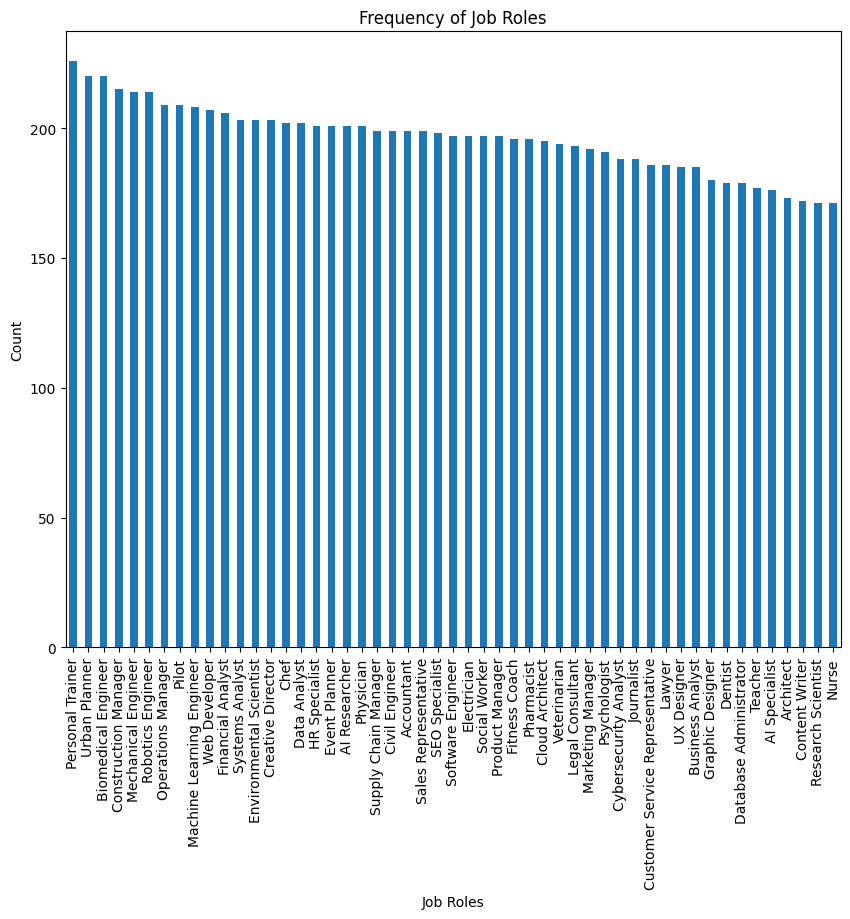

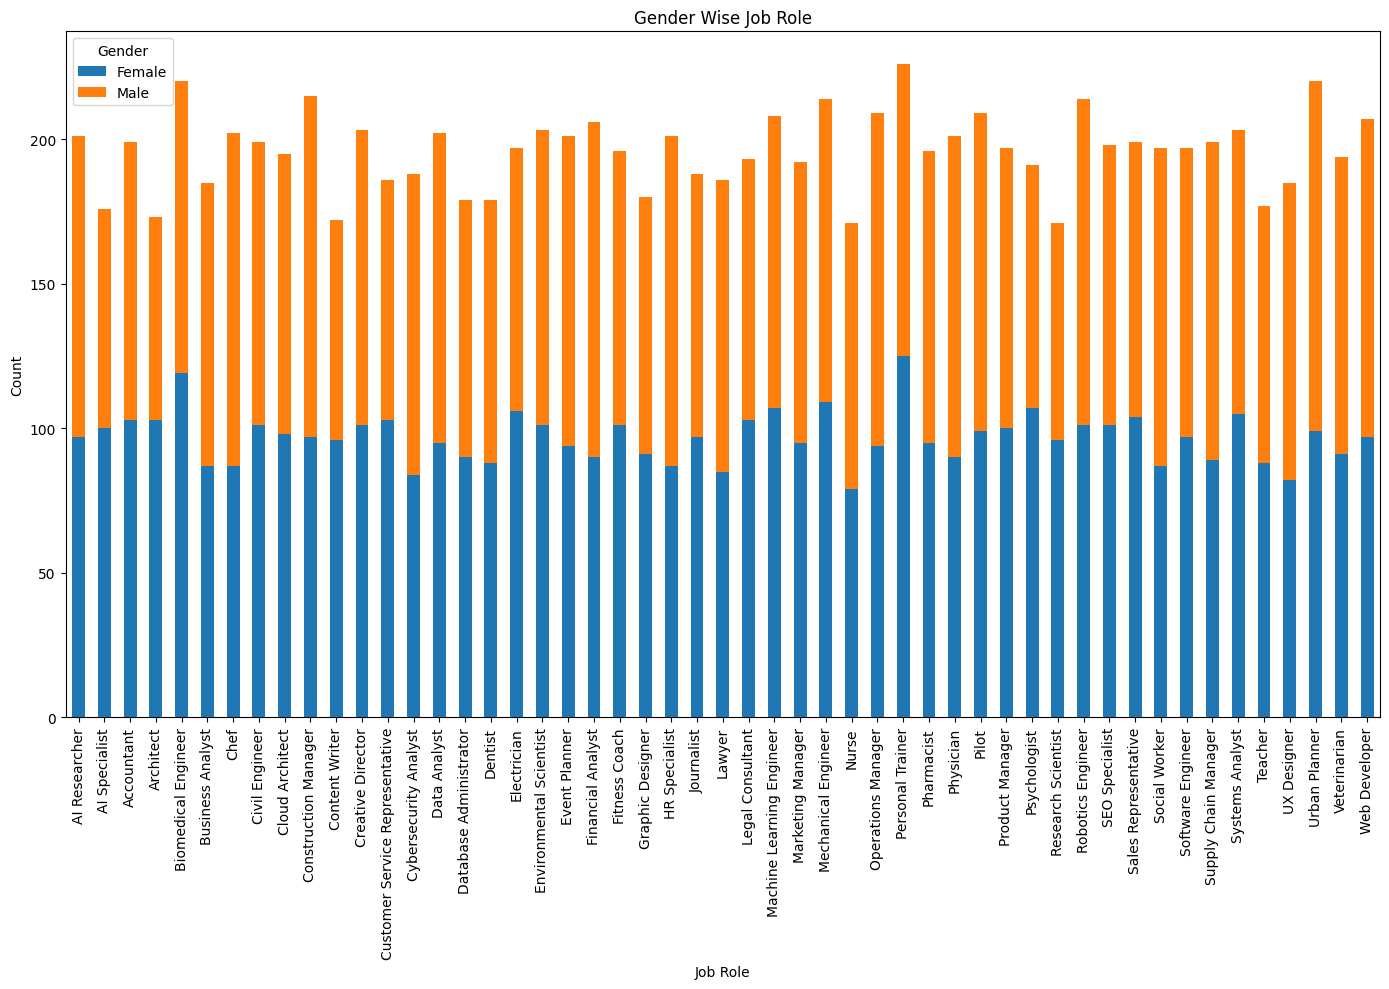

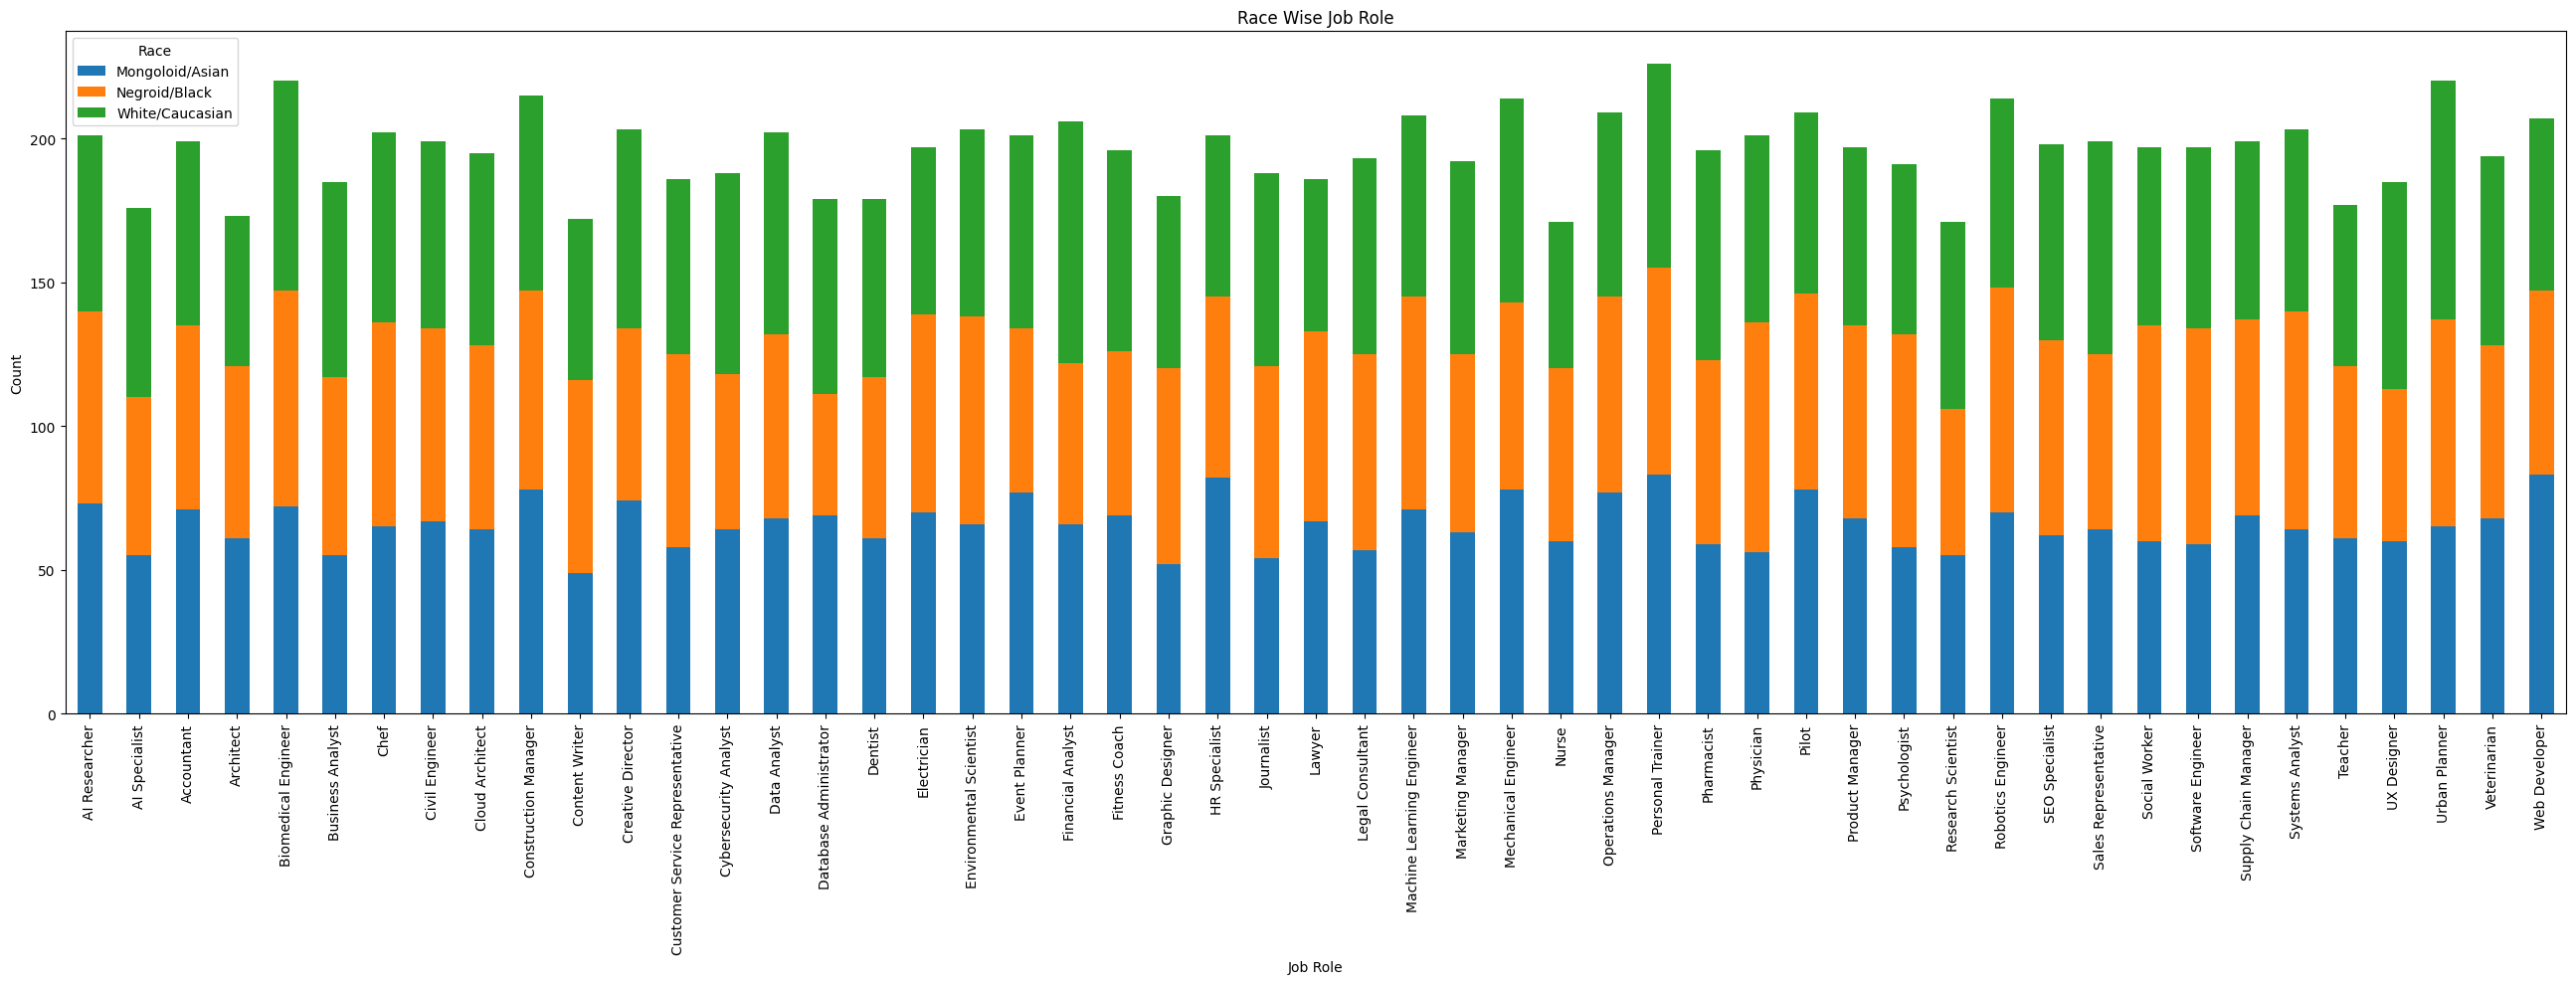

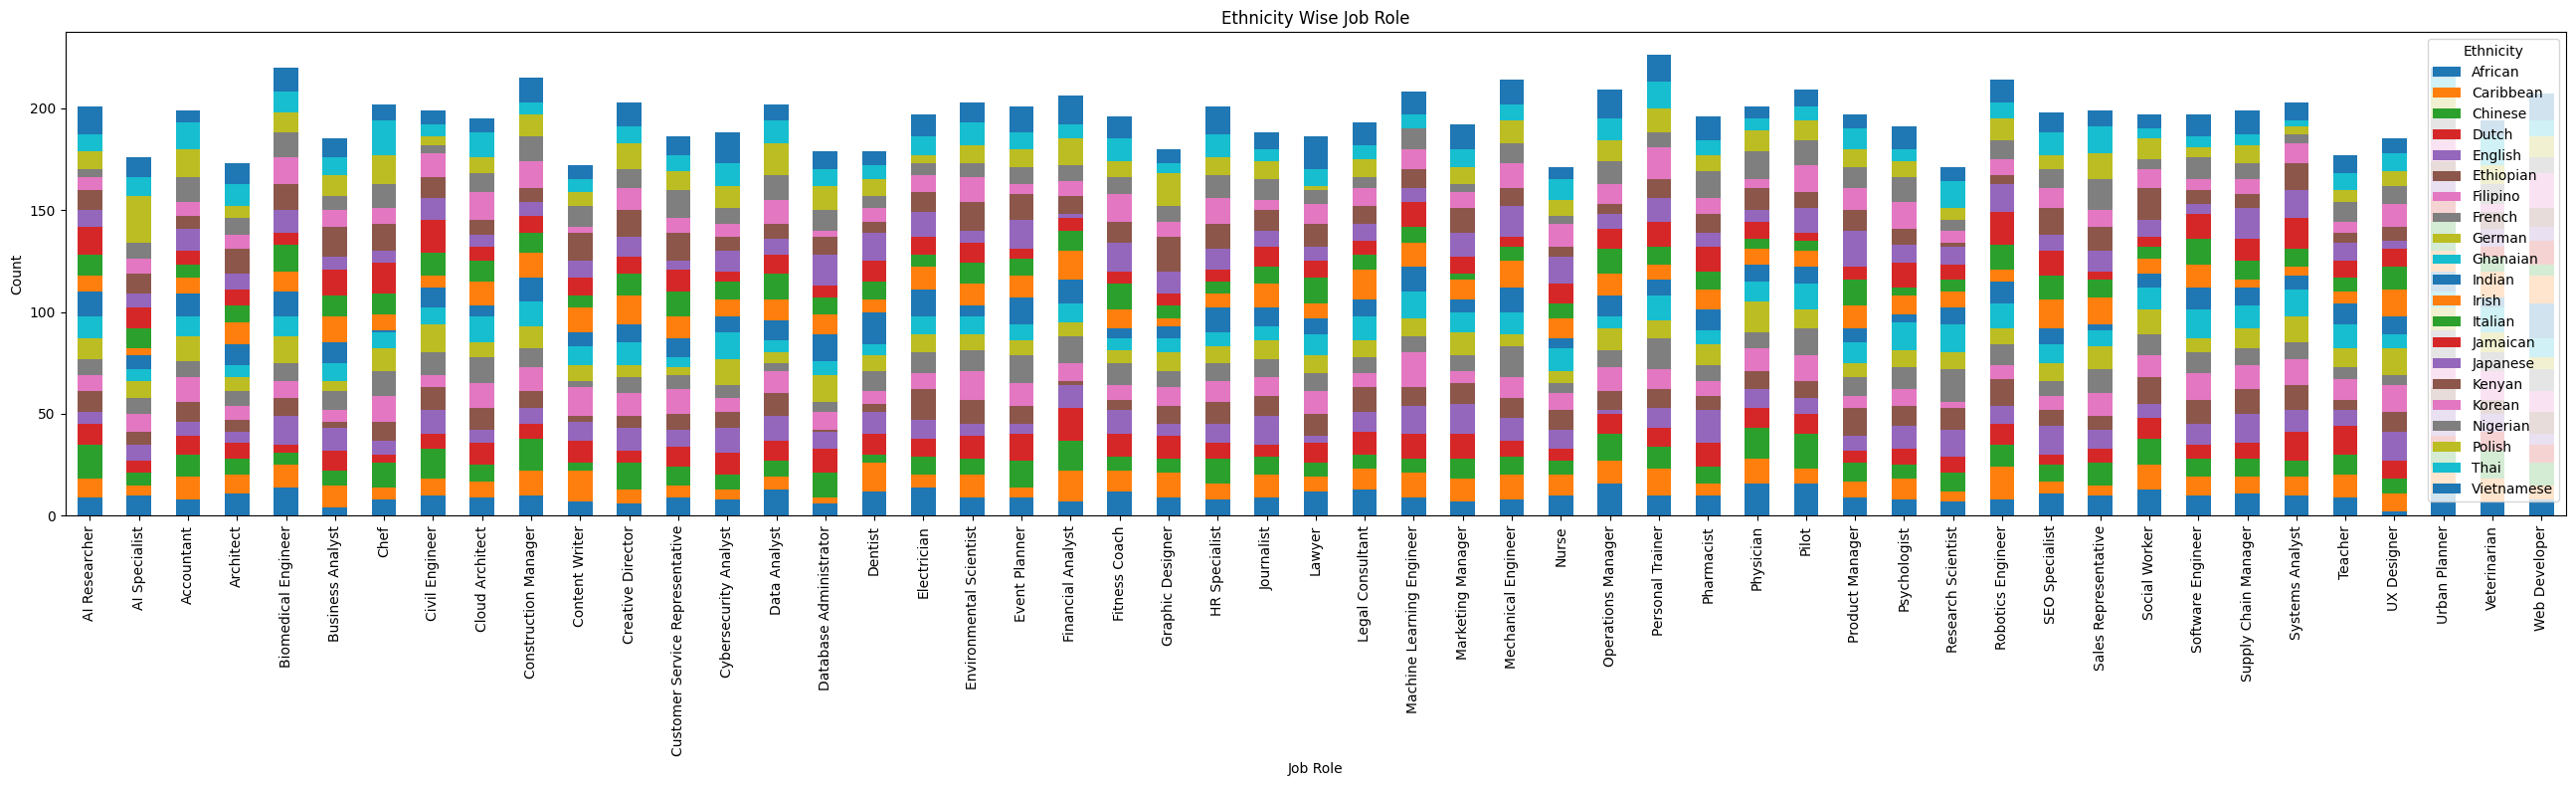

In [12]:
plot_eda(df)

# Data Cleaning

In [13]:
df['Cleaned Resume'] = df.Resume.apply(lambda x: clean_resume(x))
df.head(5)

,Job Applicant Name,Age,Gender,Race,Ethnicity,Resume,Job Roles,Job Description,Best Match,Cleaned Resume
0,Daisuke Mori,29,Male,Mongoloid/Asian,Vietnamese,"Proficient in Injury Prevention, Motivation, N...",Fitness Coach,A Fitness Coach is responsible for helping cl...,0,Proficient in Injury Prevention Motivation Nut...
1,Taichi Shimizu,31,Male,Mongoloid/Asian,Filipino,"Proficient in Healthcare, Pharmacology, Medica...",Physician,"Diagnose and treat illnesses, prescribe medica...",0,Proficient in Healthcare Pharmacology Medical ...
2,Sarah Martin,46,Female,White/Caucasian,Dutch,"Proficient in Forecasting, Financial Modelling...",Financial Analyst,"As a Financial Analyst, you will be responsibl...",0,Proficient in Forecasting Financial Modelling ...
3,Keith Hughes,43,Male,Negroid/Black,Caribbean,"Proficient in Budgeting, Supply Chain Optimiza...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1,Proficient in Budgeting Supply Chain Optimizat...
4,James Davis,49,Male,White/Caucasian,English,"Proficient in Logistics, Negotiation, Procurem...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1,Proficient in Logistics Negotiation Procuremen...


# Create copies of the cleaned dataset

In [14]:
df_best_match = df.copy()
df_job_role = df.copy()

# Pre process - Target is Best Match

In [15]:
# Remove common words from resumes with same job role
all_words = ' '.join(df_best_match["Cleaned Resume"]).split()
word_counts = Counter(all_words)
word_freq = pd.DataFrame(word_counts.most_common(25), columns=["Word", "Frequency"])

In [16]:
#Removing common words
exclusions = ["in", "holds", "and", "the", "proficient", "with", "level", "experience",
               "field", "a", "degree", "certifications", "such", "as", "skilled",
                      "delivering", "results", "adapting", "to", "dynamic", "environments"]

df_best_match['Cleaned Resume'] = pre_process(df_best_match['Cleaned Resume'],
                                               stopwords, exclusions, stemmer)
df_best_match.head(5)

,Job Applicant Name,Age,Gender,Race,Ethnicity,Resume,Job Roles,Job Description,Best Match,Cleaned Resume
0,Daisuke Mori,29,Male,Mongoloid/Asian,Vietnamese,"Proficient in Injury Prevention, Motivation, N...",Fitness Coach,A Fitness Coach is responsible for helping cl...,0,injuri prevent motiv nutrit health coach stren...
1,Taichi Shimizu,31,Male,Mongoloid/Asian,Filipino,"Proficient in Healthcare, Pharmacology, Medica...",Physician,"Diagnose and treat illnesses, prescribe medica...",0,healthcar pharmacolog medic terminolog patient...
2,Sarah Martin,46,Female,White/Caucasian,Dutch,"Proficient in Forecasting, Financial Modelling...",Financial Analyst,"As a Financial Analyst, you will be responsibl...",0,forecast financi model excel budget market res...
3,Keith Hughes,43,Male,Negroid/Black,Caribbean,"Proficient in Budgeting, Supply Chain Optimiza...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1,budget suppli chain optim risk manag logist pr...
4,James Davis,49,Male,White/Caucasian,English,"Proficient in Logistics, Negotiation, Procurem...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1,logist negoti procur suppli chain optim budget...


In [17]:
required_text_best_match = df_best_match['Cleaned Resume'].values
required_target_best_match = df_best_match['Best Match'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english')
word_vectorizer.fit(required_text_best_match)
word_features_best_match = word_vectorizer.transform(required_text_best_match)

## Supervised Learning

#### 70-30 split

In [18]:
X_train,X_test,y_train,y_test = train_test_split(word_features_best_match,required_target_best_match,
                                                 random_state=42, test_size=0.30,
                                                 shuffle=True, stratify=required_target_best_match)

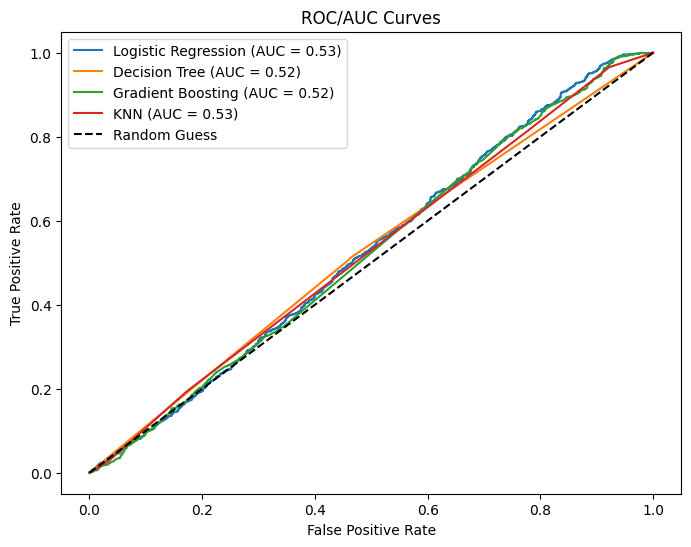

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.517000   0.516914  0.517000  0.516952
1        Decision Tree  0.524000   0.523924  0.524000  0.523958
2    Gradient Boosting  0.508000   0.503971  0.508000  0.495065
3                  KNN  0.514667   0.515045  0.514667  0.514773


In [19]:
results_df = evaluate_classifiers_with_roc_auc_graph(X_train, y_train, X_test, y_test)
print(results_df)

Model with highest accuracy is Decision Tree. However, none of the accuracy are too high. Let's check fairness metric using any of the models.

## Check for fairness metric

In [20]:
X = df_best_match["Cleaned Resume"]
y = df_best_match["Best Match"]

#### Check for Gender

In [21]:
sensitive_attr = df_best_match["Gender"]
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
        X, y, sensitive_attr, test_size=0.3, random_state=42
    )
fairness_metric(X_train, y_train, X_test, y_test, s_train, s_test);

        accuracy  selection_rate
Gender                          
Female  0.491373        0.456867
Male    0.522244        0.454545


After Mitigation:

        accuracy  selection_rate
Gender                          
Female  0.498965        0.460317
Male    0.523533        0.446809


#### Check for Race

In [22]:
sensitive_attr = df_best_match["Race"]
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_attr, test_size=0.3, random_state=42
)
fairness_metric(X_train, y_train, X_test, y_test, s_train, s_test);

                 accuracy  selection_rate
Race                                     
Mongoloid/Asian  0.517553        0.463390
Negroid/Black    0.487127        0.452111
White/Caucasian  0.516473        0.451550


After Mitigation:

                 accuracy  selection_rate
Race                                     
Mongoloid/Asian  0.516550        0.462387
Negroid/Black    0.486097        0.451081
White/Caucasian  0.517442        0.452519


#### Check for Ethnicity

In [23]:
sensitive_attr = df_best_match["Ethnicity"]
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_attr, test_size=0.3, random_state=42
)
fairness_metric(X_train, y_train, X_test, y_test, s_train, s_test);

            accuracy  selection_rate
Ethnicity                           
African     0.507692        0.384615
Caribbean   0.546053        0.460526
Chinese     0.541667        0.409722
Dutch       0.541667        0.423611
English     0.503226        0.470968
Ethiopian   0.503497        0.496503
Filipino    0.514493        0.478261
French      0.489655        0.393103
German      0.507463        0.440299
Ghanaian    0.480000        0.406667
Indian      0.488722        0.436090
Irish       0.538462        0.461538
Italian     0.531915        0.489362
Jamaican    0.395349        0.457364
Japanese    0.466216        0.493243
Kenyan      0.512605        0.420168
Korean      0.500000        0.480519
Nigerian    0.459459        0.527027
Polish      0.500000        0.479167
Thai        0.508333        0.458333
Vietnamese  0.593750        0.481250


After Mitigation:

            accuracy  selection_rate
Ethnicity                           
African     0.538462        0.415385
Caribbean   0.552

# Pre process - Target is Job Role

In [24]:
#Removing biased words
bias_exclusions = ["women", "men", "male", "female", "man",
                    "mongoloid/asian", "white/caucasian", "negroid/black",
                      "mongoloid", "white", "negroid", "asian", "caucasian",
                        "black", "vietnamese", "filipino", "chinese", "irish",
                          "kenyan", "african", "ghanaian", "english", "japanese",
                            "polish", "caribbean", "french", "dutch", "german", "jamaican",
                              "korean", "indian", "nigerian", "ethiopian", "italian", "thai"]

df_job_role['Cleaned Resume'] = pre_process(df_job_role['Cleaned Resume'], stopwords,
                                             bias_exclusions, stemmer)
df_job_role.head(5)

,Job Applicant Name,Age,Gender,Race,Ethnicity,Resume,Job Roles,Job Description,Best Match,Cleaned Resume
0,Daisuke Mori,29,Male,Mongoloid/Asian,Vietnamese,"Proficient in Injury Prevention, Motivation, N...",Fitness Coach,A Fitness Coach is responsible for helping cl...,0,profici injuri prevent motiv nutrit health coa...
1,Taichi Shimizu,31,Male,Mongoloid/Asian,Filipino,"Proficient in Healthcare, Pharmacology, Medica...",Physician,"Diagnose and treat illnesses, prescribe medica...",0,profici healthcar pharmacolog medic terminolog...
2,Sarah Martin,46,Female,White/Caucasian,Dutch,"Proficient in Forecasting, Financial Modelling...",Financial Analyst,"As a Financial Analyst, you will be responsibl...",0,profici forecast financi model excel budget ma...
3,Keith Hughes,43,Male,Negroid/Black,Caribbean,"Proficient in Budgeting, Supply Chain Optimiza...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1,profici budget suppli chain optim risk manag l...
4,James Davis,49,Male,White/Caucasian,English,"Proficient in Logistics, Negotiation, Procurem...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1,profici logist negoti procur suppli chain opti...


#### Dropping redundant and sensitive features

In [25]:
df_job_role = df_job_role.drop(["Job Applicant Name", "Age", "Gender", "Race",
                                 "Ethnicity", "Resume", "Job Description", "Best Match"], axis=1)

In [26]:
df_job_role.head(5)

,Job Roles,Cleaned Resume
0,Fitness Coach,profici injuri prevent motiv nutrit health coa...
1,Physician,profici healthcar pharmacolog medic terminolog...
2,Financial Analyst,profici forecast financi model excel budget ma...
3,Supply Chain Manager,profici budget suppli chain optim risk manag l...
4,Supply Chain Manager,profici logist negoti procur suppli chain opti...


#### Remove common words and almost similar resumes with same job role

In [27]:
# Remove common words from dataset
exclusion_list = []
all_words = ' '.join(df_job_role["Cleaned Resume"]).split()
word_counts = Counter(all_words)

word_freq = pd.DataFrame(word_counts.most_common(100), columns=["Word", "Frequency"])
for index, row in word_freq.iterrows():
    if row['Frequency'] > 1000:
        exclusion_list.append(row['Word'])

df_job_role['Cleaned Resume'] = remove_texts(df_job_role['Cleaned Resume'], exclusion_list)

#Remove resumes with more than or equal to 70% similarity having same Jobe Role
similarity_threshold = 70
# List to store results
processed_subsets = [] 
# Loop over 'Job Roles' feature
for grp, subset in df_job_role.groupby("Job Roles"):
    rows_to_drop = set()
    
    for i in range(len(subset)):
        if i in rows_to_drop: # Skip if already marked for dropping
            continue
        for j in range(i + 1, len(subset)):
            if j in rows_to_drop: # Skip if already marked for dropping
                continue
            str1 = subset["Cleaned Resume"].iloc[i]
            str2 = subset["Cleaned Resume"].iloc[j]
            # Calculate partial ratio for flexibility
            score = fuzz.partial_ratio(str1, str2)

            if score >= similarity_threshold:
                rows_to_drop.add(j) # Mark the later row for dropping
   
    rows_to_drop_index = subset.index[list(rows_to_drop)]
    subset = subset.drop(rows_to_drop_index, axis=0)

    # Append processed subset
    processed_subsets.append(subset)

# Combine all processed subsets
processed_df_job_role = pd.concat(processed_subsets)
processed_df_job_role.head(5)

,Job Roles,Cleaned Resume
27,AI Researcher,innov program methodolog machin learn deep lea...
133,AI Researcher,scienc program deep learn machin learn artific...
157,AI Researcher,innov artifici intellig methodolog scientif wr...
206,AI Researcher,methodolog scienc innov program scientist
225,AI Researcher,deep learn innov artifici intellig machin lear...


## Supervised Learning

#### Convert categorical job role to numeric

In [29]:
var_mod = ['Job Roles']
le = LabelEncoder()
for i in var_mod:
    processed_df_job_role[i] = le.fit_transform(processed_df_job_role[i])

#### Vectorize

In [30]:
required_text = processed_df_job_role['Cleaned Resume']
required_target = processed_df_job_role['Job Roles']

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english')
word_vectorizer.fit(required_text)
word_features = word_vectorizer.transform(required_text)

#### 65-35 split

In [31]:
X_train,X_test,y_train,y_test = train_test_split(word_features,required_target,random_state=42,
                                                  test_size=0.35, shuffle=True,
                                                    stratify=required_target)

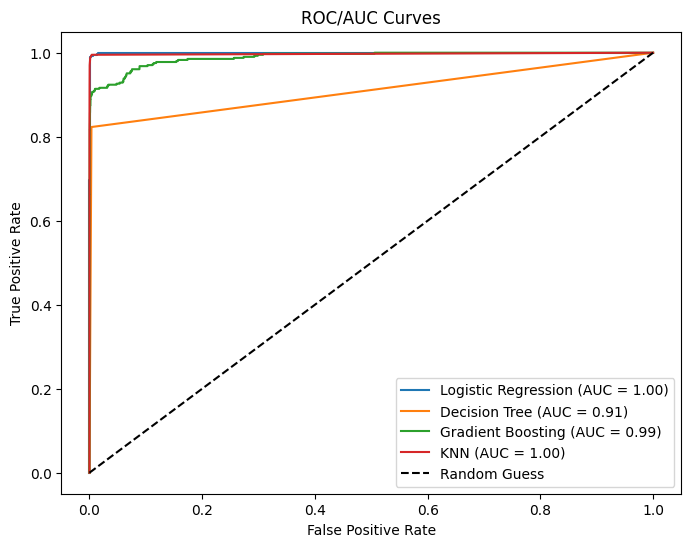

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.977887   0.978724  0.977887  0.977246
1        Decision Tree  0.823096   0.871997  0.823096  0.830561
2    Gradient Boosting  0.879607   0.919330  0.879607  0.887633
3                  KNN  0.975430   0.977682  0.975430  0.974585


In [32]:
results_df = evaluate_classifiers_with_roc_auc_graph(X_train, y_train, X_test, y_test)
print(results_df)

Logistic Regression model has the highest accuracy.

# Conclusion #
Models with Job Roles as target has much higher accuracy than models with Best Match as target. Also, we had already removed sensitive keywords, features from Models with Job Roles. So, Models with Job Roles never learn about sensitive groups. So, Logistic Regression model with target as Job Roles gave the highest accuracy.